<a href="https://colab.research.google.com/github/Seb207/Market-Context-Project/blob/main/Irrationality%20Index/DL_Index_Outline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Index Outline

Outline for deep learning model to analze market factors and output irrationality index.

Model: Transformer

Data_Format: history data in second

- Positional Embedding Class
- Transformer Encoder Block Class
- Prediction Head Class
- Irrationality Index Class
- Model Manager Class

# Hypothesis

**Factors**
- Volatility: VIX (moving avg. - 20 days)
- Volume: Trading Volume (periodic average - 20 days)
- Fixed Income (macro): US bond rate momentum
- Periodicity: past rate of return (20, 60, 120 days)
- Small vs. Big performace: (QQQ -> factor: IWM, IWM -> factor: QQQ) rate of return
-

**Tested Data**
- SPY (S&P 500)
- QQQ (Nasdaq)
- DIA (Dow Jones)
- IWM (Russell 2000)
- Individual stocks

1.

# Import Libraries

In [174]:
import gc
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.stats as stats

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout,
    LayerNormalization, MultiHeadAttention,
    Lambda
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, mean_absolute_percentage_error

import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

Problem 1:
- As factors have each different absolute values, output could be affected by its absolute value if directly used as input.

Solution:
- Used data normalization (z-score)

In [175]:
df = pd.read_csv('../Data/Index/1424_daily_cleaned.csv', index_col=0, parse_dates=True)

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2501 entries, 2015-01-02 to 2024-12-31
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   QQQ_Price_Close  2501 non-null   float64
 1   QQQ_Volume       2501 non-null   float64
 2   SPY_Price_Close  2501 non-null   float64
 3   SPY_Volume       2501 non-null   float64
 4   US10_Mid_Price   2501 non-null   float64
 5   US10_Mid_Yld     2501 non-null   float64
 6   US30_Mid_Price   2501 non-null   float64
 7   US30_Mid_Yld     2501 non-null   float64
 8   GLD_Price_Close  2501 non-null   float64
 9   GLD_Volume       2501 non-null   float64
 10  IWM_Price_Close  2501 non-null   float64
 11  IWM_Volume       2501 non-null   float64
 12  VIX              2501 non-null   float64
dtypes: float64(13)
memory usage: 273.5 KB


In [177]:
input_features = ['QQQ_Volume', 'US10_Mid_Yld', 'GLD_Price_Close', 'IWM_Price_Close', 'VIX']
target = 'QQQ_Price_Close' # Assume the target to be the price data in this case.

In [178]:
correlation_df = df.corr()

print(correlation_df[target].sort_values(ascending=False))

QQQ_Price_Close    1.000000
SPY_Price_Close    0.993463
GLD_Price_Close    0.947892
IWM_Price_Close    0.897019
US10_Mid_Yld       0.452836
US30_Mid_Yld       0.397922
QQQ_Volume         0.229553
VIX                0.123486
IWM_Volume         0.075931
GLD_Volume        -0.077556
US30_Mid_Price    -0.109676
US10_Mid_Price    -0.131958
SPY_Volume        -0.307432
Name: QQQ_Price_Close, dtype: float64


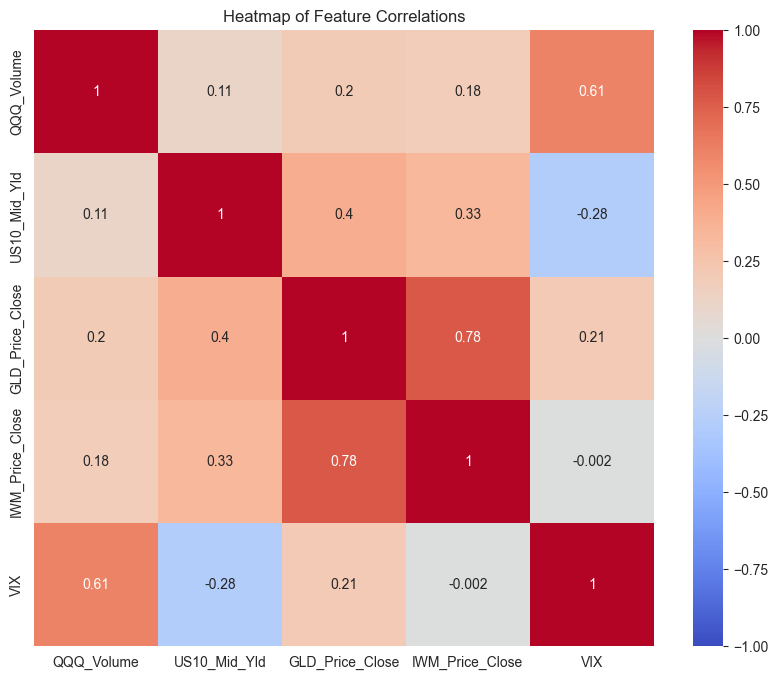

In [179]:
correlation_matrix = df[input_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            center=0)
plt.title('Heatmap of Feature Correlations')
plt.show()

In [180]:
selected_features = [target] + input_features
data_array = df[selected_features].values
num_features = len(selected_features)

In [181]:
def create_dataset(dataset, look_back=1, target_col_index=0):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        seq_input = dataset[i: (i + look_back), :]
        X.append(seq_input)
        seq_target = dataset[i + look_back, target_col_index]
        Y.append(seq_target)
    return np.array(X), np.array(Y)

In [182]:
look_back = 20 # days 20 days --> 1 month
X, Y = create_dataset(data_array,
                      look_back,
                      target_col_index=0
                      )
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=False
                                                    )
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp,
                                                  test_size=0.5,
                                                  random_state=42,
                                                  shuffle=False
                                                  )

In [183]:
n_samples, n_timesteps, n_features = X_train.shape
X_train_2d = X_train.reshape(n_samples * n_timesteps, n_features)

scaler = StandardScaler()
X_train_scaled_2d = scaler.fit_transform(X_train_2d)

X_train_scaled = X_train_scaled_2d.reshape(n_samples, n_timesteps, n_features)

X_val_2d = X_val.reshape(-1, n_features)
X_val_scaled = scaler.transform(X_val_2d).reshape(X_val.shape)

X_test_2d = X_test.reshape(-1, n_features)
X_test_scaled = scaler.transform(X_test_2d).reshape(X_test.shape)

In [184]:
scaler_y = StandardScaler()
Y_train_scaled = scaler_y.fit_transform(Y_train.reshape(-1, 1)).flatten()
Y_val_scaled = scaler_y.transform(Y_val.reshape(-1, 1)).flatten()
Y_test_scaled = scaler_y.transform(Y_test.reshape(-1, 1)).flatten()

In [185]:
print(f"X_train shape: {X_train_scaled.shape}")
print(f"Y_train shape: {Y_train_scaled.shape}")
print(f"X_val shape: {X_val_scaled.shape}")
print(f"Y_val shape: {Y_val_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")
print(f"Y_test shape: {Y_test_scaled.shape}")

X_train shape: (1984, 20, 6)
Y_train shape: (1984,)
X_val shape: (248, 20, 6)
Y_val shape: (248,)
X_test shape: (248, 20, 6)
Y_test shape: (248,)


# Hyperparameters

**Model Architecture**
- input_dim: number of factors
- seq_len: length of data processed in the model at once
- d_model: dimension of the model
- num_heads: number of heads for multi-head attention (should be divisor of d_model)
- d_ff: inner dimension of feed forward (4x of d_model in usual)
- num_layers: number of transformer encoder block (depth of model)
- output_dim: output dimension

**Training and Normalization**
- dropout_rate
- learning_rate
- batch_size

# Transformer Encoder Block Class





In [186]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        if embed_dim % num_heads != 0:
            raise ValueError("`embed_dim` must be divisible by `num_heads`.")
        key_dim = embed_dim // num_heads
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate

        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.supports_masking = True

    def call(self, inputs, mask=None, training=False):
        attn_output = self.att(inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'dropout_rate': self.dropout_rate
        })
        return config

# Positional Embedding Class

In [187]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, embed_dim, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_len = max_len
        self.embed_dim = embed_dim

    def build(self, input_shape):
        pos = np.arange(self.max_len)[:, np.newaxis]  # (max_len, 1)
        i = np.arange(self.embed_dim)[np.newaxis, :]  # (1, embed_dim)
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(self.embed_dim))
        angle_rads = pos * angle_rates  # (max_len, embed_dim)

        # apply sin to even indices; cos to odd indices
        pos_encoding = np.zeros_like(angle_rads, dtype=np.float32)
        pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
        pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])

        # shape -> (1, max_len, embed_dim) to allow broadcasting with batch
        pos_encoding = pos_encoding[np.newaxis, ...]
        self.pos_encoding = tf.constant(pos_encoding, dtype=tf.float32)
        super(PositionalEncoding, self).build(input_shape)

    def call(self, x):
        # x shape: (batch, seq_len, embed_dim)
        seq_len = tf.shape(x)[1]
        return x + self.pos_encoding[:, :seq_len, :]

    def get_config(self):
        config = super().get_config()
        config.update({'max_len': self.max_len, 'embed_dim': self.embed_dim})
        return config

# Transformer Model Building Function

In [188]:
def build_transformer_model_wrapper(
    look_back_size, num_features,
    embed_dim=64, num_heads=4, ff_dim=128,
    num_transformer_blocks=2, dropout_rate=0.2, learning_rate=0.001):

    return build_transformer_model(
        look_back_size, num_features, embed_dim, num_heads,
        ff_dim, num_transformer_blocks, dropout_rate, learning_rate
    )

In [189]:
def build_transformer_model(look_back_size, num_features,
                           embed_dim=64, num_heads=4,
                           ff_dim=128, num_transformer_blocks=2,
                           dropout_rate=0.2, learning_rate=0.001):
    inputs = Input(shape=(look_back_size, num_features))
    x = Dense(embed_dim)(inputs)
    x = PositionalEncoding(look_back_size, embed_dim)(x)

    # causal mask (no look-ahead): shape (1, seq_len, seq_len) -> broadcasts over batch
    causal_mask = tf.cast(
        tf.linalg.band_part(tf.ones((look_back_size, look_back_size)), -1, 0),
        dtype=tf.bool
    )
    causal_mask = tf.expand_dims(causal_mask, axis=0)

    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x, mask=causal_mask)

    x = Lambda(lambda t: tf.reduce_mean(t, axis=1))(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.Huber(delta=1.0),
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae'])
    return model

# Training & Tuning Data

In [190]:
param_distributions = {
    'model__embed_dim': [64, 128, 256, 384, 512],
    'model__num_heads': [1, 2, 4, 8],
    'model__ff_dim': [128, 256, 512, 1024, 2048],
    'model__num_transformer_blocks': [1, 2, 3, 4],
    'model__dropout_rate': stats.uniform(0.05, 0.45),
    'model__learning_rate': stats.loguniform(1e-5, 1e-2),
    'batch_size': [16, 32, 64, 128, 256],
    'epochs': [20, 50, 100]
}

In [191]:
print("Starting hyperparameter tuning using RandomizedSearchCV...")

# Create a KerasRegressor wrapper
# The build_fn is passed the fixed look_back and num_features.
# Other parameters like embed_dim, num_heads etc. will be passed by RandomizedSearchCV.
keras_model = KerasRegressor(
    model=build_transformer_model,
    look_back_size=look_back,
    num_features=num_features,
    verbose=0,
    optimizer="adam",
    loss="huber"
)

callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
]

random_search = RandomizedSearchCV(
    estimator=keras_model,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=1,
    random_state=42
)

random_search.fit(
    X_train_scaled, Y_train_scaled,
    validation_data=(X_val_scaled, Y_val_scaled),
    callbacks=callbacks_list
)

print("\n" + "=" * 60)
print("Hyperparameter tuning completed!")
print("=" * 60)

Starting hyperparameter tuning using RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/ahnsebin/Documents/Personal Project/Quant/Market-Context-Project/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'lambda_60' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/ahnsebin/Documents/Personal Project/Quant/Market-Context-Project/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'lambda_61' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/ahnsebin/Documents/Personal Project/Quant/Market-Context-Project/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'lambda_62' (of type Lambda) was passed an input with a mask attached t

KeyboardInterrupt: 

In [ ]:
# Get the best parameters and best score
best_params = random_search.best_params_
best_rmse = np.sqrt(-random_search.best_score_)

# Structure the best_result for consistency with subsequent cells
best_result = {
    'embed_dim': best_params['model__embed_dim'],
    'num_heads': best_params['model__num_heads'],
    'ff_dim': best_params['model__ff_dim'],
    'num_transformer_blocks': best_params['model__num_transformer_blocks'],
    'dropout_rate': best_params['model__dropout_rate'],
    'learning_rate': best_params['model__learning_rate'],
    'batch_size': best_params['batch_size'],
    'epochs': best_params['epochs'],
    'rmse': best_rmse,
    'val_loss': -random_search.best_score_ # Use the best negative MSE as val_loss placeholder
}

print("\nTop Parameter Combination:")
print(best_result)

tf.keras.backend.clear_session()
gc.collect()

In [ ]:
print("\n" + "="*60)
print("Best Parameters Found (from RandomizedSearchCV):")
print("="*60)
for param, value in best_result.items():
    if param not in ['val_loss', 'rmse']:
        print(f"{param:25s}: {value}")
print(f"{'Validation RMSE':25s}: {best_result['rmse']:.4f}")
print(f"{'Best Val Loss (neg_mse)':25s}: {best_result['val_loss']:.6f}") # Note: This is negative MSE from scoring
print("="*60)

In [ ]:
final_model = build_transformer_model(
    look_back, num_features,
    embed_dim=best_result['embed_dim'],
    num_heads=best_result['num_heads'],
    ff_dim=best_result['ff_dim'],
    num_transformer_blocks=best_result['num_transformer_blocks'],
    dropout_rate=best_result['dropout_rate'],
    learning_rate=best_result['learning_rate']
)

# Callbacks are now defined above and used by RandomizedSearchCV directly.
# These definitions are for the final model training if needed with specific patience.
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)

model_check_point = ModelCheckpoint(
    'best_model.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

In [ ]:
final_model.summary()

In [ ]:
print("\n--- Training Final Model ---")
history = final_model.fit(
    X_train_scaled,
    Y_train_scaled,
    epochs=best_result['epochs'],
    batch_size=best_result['batch_size'],
    validation_data=(X_val_scaled, Y_val_scaled),
    callbacks=[early_stop, reduce_lr, model_check_point],
    verbose=2
)

print("Completed training the final model.")

In [ ]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # MAE plot
    axes[1].plot(history.history['mae'], label='Training MAE')
    axes[1].plot(history.history['val_mae'], label='Validation MAE')
    axes[1].set_title('Model MAE')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_history(history)

# Test Model

In [ ]:
test_predict_scaled = final_model.predict(X_test_scaled)

predicted_prices = scaler_y.inverse_transform(test_predict_scaled).flatten()
actual_prices = scaler_y.inverse_transform(Y_test_scaled.reshape(-1, 1)).flatten()

In [ ]:
test_rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
test_mae = mean_absolute_error(actual_prices, predicted_prices)
test_r2 = r2_score(actual_prices, predicted_prices)
mape = mean_absolute_percentage_error(actual_prices, predicted_prices)

print(f"\n--- Price Prediction Performance Evaluation ---")
print(f"Test Data RMSE: {test_rmse:.4f}")

In [ ]:
test_dates = df.index[len(df) - len(Y_test) - 1 : len(df) - 1]

window = (-49,-1)

plt.figure(figsize=(12, 6))
plt.plot(test_dates[window[0]:window[1]], actual_prices[window[0]:window[1]], label='Actual Price')
plt.plot(test_dates[window[0]:window[1]], predicted_prices[window[0]:window[1]], label='Predicted Price')
plt.title(f'Price Prediction vs. Actual (RMSE: {test_rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
def comprehensive_evaluation(actual, predicted, model):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    mape = mean_absolute_error(actual, predicted)

    test_dates = df.index[len(df) - len(Y_test) - 1 : len(df) - 1]
    actual_dir = np.sign(np.diff(actual))
    pred_dir = np.sign(np.diff(predicted))
    dir_acc = accuracy_score((actual_dir > 0).astype(int),
                             (pred_dir > 0).astype(int))

    residuals = actual - predicted

    print("\n=======================================================")
    print("           Transformer Price Performance Metrics         ")
    print("=======================================================")
    print(f"1. RMSE (Root Mean Squared Error):        {rmse:.4f}")
    print(f"2. MAE (Mean Absolute Error):             {mae:.4f}")
    print(f"3. MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    print(f"4. R²:                                    {r2:.4f}")
    print("=======================================================")

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    axes[0, 0].scatter(actual, predicted, alpha=0.5)
    axes[0, 0].plot([actual.min(), actual.max()],
                    [actual.min(), actual.max()],
                    'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Price')
    axes[0, 0].set_ylabel('Predicted Price')
    axes[0, 0].set_title('Actual vs Predicted')
    axes[0, 0].grid(True)

    axes[0, 1].hist(residuals, bins=50, edgecolor='black')
    axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[0, 1].set_xlabel('Residual')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title(f'Residual Distribution (Mean: {residuals.mean():.2f})')
    axes[0, 1].grid(True)

    axes[1, 0].plot(test_dates, residuals)
    axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Residual')
    axes[1, 0].set_title('Residuals Over Time')
    axes[1, 0].xaxis.set_major_locator(plt.MaxNLocator(10))
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True)

    stats.probplot(residuals, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'directional_accuracy': dir_acc,
        'residual_mean': residuals.mean(),
        'residual_std': residuals.std()
    }

In [ ]:
_ = comprehensive_evaluation(actual_prices, predicted_prices, final_model)

# Model Manager

In [8]:
class ModelManager:
    def __init__(self, model, base_dir="../trained_model"):
        self.model = model
        self.base_dir = base_dir
        tf.io.gfile.makedirs(self.base_dir)

    def save_weights(self, tag):
        file_path = os.path.join(self.base_dir, f"weights_{tag}.h5")
        self.model.save_weights(file_path)
        print(f"Weights saved: {file_path}")
        return file_path

    def load_weights(self, tag):
        file_path = os.path.join(self.base_dir, f"weights_{tag}.h5")
        try:
            self.model.load_weights(file_path)
            print(f"Weights loaded: {file_path}")
            return True
        except Exception as e:
            print(f"Error loading weights: {e}")
            return False

    def save_model(self, tag, save_format='tf'):
        model_path = os.path.join(self.base_dir, f"model_{tag}")
        # save_format: 'tf' -> saved model directory, 'h5' -> single file if desired
        if save_format == 'h5':
            self.model.save(f"{model_path}.h5", include_optimizer=True)
        else:
            self.model.save(model_path)  # SavedModel dir
        print(f"Model saved: {model_path}")
        return model_path

    @staticmethod
    def load_full_model(tag, base_dir="../trained_model"):
        model_path = os.path.join(base_dir, f"model_{tag}")
        try:
            loaded_model = tf.keras.models.load_model(model_path)
            print(f"Model loaded: {model_path}")
            return loaded_model
        except Exception as e:
            print(f"Error loading model: {e}")
            return None

In [ ]:
mm = ModelManager(final_model, base_dir="../trained_model")
mm.save_model("transformer_v1", save_format='tf')

# Further Steps

- Calculate irrationality index based on prediction errors and the actual market movement.
- Error = Actual - Predicted
- I = (Error - Mean(Error)) / StdDev(Error)